In [1]:
import os
import os
from PIL import Image, ImageEnhance
import random
import shutil
import random
from collections import defaultdict
import os
import random
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
import os
import random
from PIL import Image, ImageEnhance, ImageFilter, ImageOps


- Traverse through each subfolder in the root directory.
- Count the number of images in each subfolder.
- Determine the minimum number of images among all the subfolders.
- Calculate the number of images to allocate for each category (train, val, test) based on the minimum count and the desired distribution.
- Create new folders (train, val, test) if they don't exist already.
- Copy the required number of images from each subfolder to the respective category folders, maintaining the desired distribution.

In [ ]:
# Howto:
# https://medium.com/@siromermer/pipeline-for-every-pytorch-image-classification-problem-creating-dataset-f0f57d6ae225

In [2]:
root_dir = '../Downloading_images/data/'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
test_dir = os.path.join(root_dir, 'test')

# Ensure the existence of train, val, and test directories
for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)

# Count images in each class
class_counts = defaultdict(int)
for subdir, _, files in os.walk(root_dir):
    if "websites" not in subdir:  # Exclude the "websites" folder
        if files:  # Only process directories with files (images)
            class_id = os.path.basename(subdir)
            class_counts[class_id] += len(files)

# Determine the minimum count
min_count = min(class_counts.values())

# Extract class IDs from class_counts dictionary
class_ids = list(class_counts.keys())

# Define distribution percentages based on the minimum count
train_percent = 0.7
val_percent = 0.15
test_percent = 0.15

# Calculate the rounded distribution counts to balance test and val directories
val_count = round(min_count * val_percent)
test_count = round(min_count * test_percent)

# Adjust train count to ensure the sum of train, val, and test counts is equal to min_count
train_count = min_count - val_count - test_count

print(f" val_count = {val_count}, train_count = {train_count}, test_count = {test_count } ") 

# Iterate over each class directory
for class_id in class_ids:
    class_dir = os.path.join(root_dir, class_id)
    
    # List all images in the class directory
    images = os.listdir(class_dir)
    
    # Shuffle the images to distribute randomly
    random.shuffle(images)
    
    # Initialize counts for train, val, and test directories
    train_images = 0
    val_images = 0
    test_images = 0
    
    # Distribute images into train, val, and test directories
    for image in images:
        src = os.path.join(class_dir, image)
        
        # Randomly select the destination directory based on the distribution
        if train_images < train_count:
            dst_dir = train_dir
            train_images += 1
        elif val_images < val_count:
            dst_dir = val_dir
            val_images += 1
        elif test_images < test_count:  # Check if the test count has been reached
            dst_dir = test_dir
            test_images += 1
        else:
            break  # Stop adding images to the test directory once the count is reached
        
        # Create the corresponding subfolder in the destination directory if it doesn't exist
        dst_class_dir = os.path.join(dst_dir, class_id)
        os.makedirs(dst_class_dir, exist_ok=True)
        
        # Copy the image to the destination directory while preserving the subfolder structure
        dst = os.path.join(dst_class_dir, image)
        shutil.copy(src, dst)

    # Print the count of images added from each class into each category
    print(f"Class {class_id}: Train - {train_images}, Val - {val_images}, Test - {test_images}")

print("Images distributed successfully.")

 val_count = 147, train_count = 684, test_count = 147 
Class 130228: Train - 684, Val - 147, Test - 147
Class 47892: Train - 684, Val - 147, Test - 147
Class 48537: Train - 684, Val - 147, Test - 147
Class 48681: Train - 684, Val - 147, Test - 147
Class 593040: Train - 684, Val - 147, Test - 147
Class 59549: Train - 684, Val - 147, Test - 147
Class 83653: Train - 684, Val - 147, Test - 147
Class 914922: Train - 684, Val - 147, Test - 147
Images distributed successfully.


In [3]:
# Function to count the total number of images in a directory
def count_images_in_directory(directory):
    total_images = 0
    for subdir, _, files in os.walk(directory):
        # Exclude the root directory itself
        if subdir != directory:
            total_images += len(files)
    return total_images

# Calculate total count of images in train, val, and test folders
total_train_images = count_images_in_directory(train_dir)
total_val_images = count_images_in_directory(val_dir)
total_test_images = count_images_in_directory(test_dir)

# Print the counts
print("Total number of images in train directory:", total_train_images)
print("Total number of images in val directory:", total_val_images)
print("Total number of images in test directory:", total_test_images)


Total number of images in train directory: 5472
Total number of images in val directory: 1176
Total number of images in test directory: 1176


# Making more images through transformations

In [4]:
# Function to apply transformations to an image
def apply_transformations(image):
    # Random rotation
    angle = random.randint(-10, 10)
    transformed_image = image.rotate(angle, resample=Image.BICUBIC)
    
    # Resizing and Cropping
    width, height = transformed_image.size
    crop_size = min(width, height)
    transformed_image = ImageOps.fit(transformed_image, (crop_size, crop_size))

    # Horizontal and Vertical Flips
    if random.random() > 0.5:
        transformed_image = transformed_image.transpose(Image.FLIP_LEFT_RIGHT)
    if random.random() > 0.5:
        transformed_image = transformed_image.transpose(Image.FLIP_TOP_BOTTOM)
    
    # Color Jittering
    brightness_factor = random.uniform(0.8, 1.2)
    contrast_factor = random.uniform(0.8, 1.2)
    saturation_factor = random.uniform(0.8, 1.2)
    hue_factor = random.uniform(-0.1, 0.1)
    transformed_image = ImageEnhance.Brightness(transformed_image).enhance(brightness_factor)
    transformed_image = ImageEnhance.Contrast(transformed_image).enhance(contrast_factor)
    transformed_image = ImageEnhance.Color(transformed_image).enhance(saturation_factor)
    transformed_image = transformed_image.convert('HSV')
    transformed_image = ImageEnhance.Color(transformed_image).enhance(1 + hue_factor)
    transformed_image = transformed_image.convert('RGB')

    # Gaussian Blur
    blur_radius = random.randint(0, 2)
    transformed_image = transformed_image.filter(ImageFilter.GaussianBlur(radius=blur_radius))
    
    # Brightness and Contrast Adjustment
    brightness_factor = random.uniform(0.8, 1.2)
    contrast_factor = random.uniform(0.8, 1.2)
    transformed_image = ImageEnhance.Brightness(transformed_image).enhance(brightness_factor)
    transformed_image = ImageEnhance.Contrast(transformed_image).enhance(contrast_factor)
    
    # Random Rotation, Scaling, and Translation
    scale_factor = random.uniform(0.8, 1.2)
    rotation_angle = random.randint(-10, 10)
    translate_x = random.randint(-10, 10)
    translate_y = random.randint(-10, 10)
    transformed_image = transformed_image.rotate(rotation_angle, resample=Image.BICUBIC)
    transformed_image = transformed_image.resize((int(width * scale_factor), int(height * scale_factor)), resample=Image.BICUBIC)
    transformed_image = transformed_image.transform(transformed_image.size, Image.AFFINE, (1, 0, translate_x, 0, 1, translate_y))

    # Normalization
    transformed_image = ImageOps.autocontrast(transformed_image)

    return transformed_image

def transform_images(input_dir, output_dir):
    for subdir, _, files in os.walk(input_dir):
        for filename in files:
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(subdir, filename)
                try:
                    image = Image.open(img_path)
                except (IOError, OSError) as e:
                    print(f"Skipping {filename} due to error: {e}")
                    continue
                
                # Apply transformations to the original image
                transformed_image = apply_transformations(image)
                
                # Generate new filename with '_t' suffix for transformed image
                new_filename = os.path.splitext(filename)[0] + '_t' + os.path.splitext(filename)[1]
                output_subdir = os.path.relpath(subdir, input_dir)
                output_subdir_path = os.path.join(output_dir, output_subdir)
                os.makedirs(output_subdir_path, exist_ok=True)
                output_path = os.path.join(output_subdir_path, new_filename)

                # Save transformed image
                transformed_image.save(output_path)

    print("Transformations applied successfully.")

# Define input and output directories
train_input_dir = '../Downloading_images/data/train'
val_input_dir = '../Downloading_images/data/val'
test_input_dir = '../Downloading_images/data/test'

train_output_dir = '../Downloading_images/data/train'
val_output_dir = '../Downloading_images/data/val'
test_output_dir = '../Downloading_images/data/test'

# Apply transformations to train images
transform_images(train_input_dir, train_output_dir)
print("Train transformations applied successfully.")


# Apply transformations to validation images
transform_images(val_input_dir, val_output_dir)
print("Val transformations applied successfully.")

# Apply transformations to test images
transform_images(test_input_dir, test_output_dir)
print("Test transformations applied successfully.")


Transformations applied successfully.
Transformations applied successfully.
Transformations applied successfully.
Transformations applied successfully.


## Print images to check transformation

In [22]:
def print_original_and_transformed(input_dir):
    # List all subdirectories (taxon ids) in the input directory
    subdirectories = [d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))]
    
    # Randomly select a subdirectory
    selected_subdirectory = random.choice(subdirectories)
    
    # Choose a random image from the selected subdirectory
    subdirectory_path = os.path.join(input_dir, selected_subdirectory)
    filename = random.choice(os.listdir(subdirectory_path))
    
    # Construct paths for the original and transformed images
    original_img_path = os.path.join(subdirectory_path, filename)
    transformed_filename = filename.split('.')[0] + '_t.' + filename.split('.')[1]
    transformed_img_path = os.path.join(subdirectory_path, transformed_filename)
    
    # Load and display the original image
    original_image = Image.open(original_img_path)
    print(f"Original Image: {original_img_path}")
    display(original_image.resize((200, 200)))
    
    # Check if the transformed image exists before loading and displaying it
    if os.path.exists(transformed_img_path):
        transformed_image = Image.open(transformed_img_path)
        print(f"Transformed Image: {transformed_img_path}")
        display(transformed_image.resize((200, 200)))
    else:
        print("Transformed Image not found.")

In [18]:
def count_images_in_directory(directory):
    count = 0
    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                count += 1
    return count

# Define input directories
train_input_dir = '../Downloading_images/data/train'
val_input_dir = '../Downloading_images/data/val'
test_input_dir = '../Downloading_images/data/test'

# Count the total number of images in train, val, and test directories
total_train_images = count_images_in_directory(train_input_dir)
total_val_images = count_images_in_directory(val_input_dir)
total_test_images = count_images_in_directory(test_input_dir)

print("Total number of images in train directory:", total_train_images)
print("Total number of images in val directory:", total_val_images)
print("Total number of images in test directory:", total_test_images)


Total number of images in train directory: 10944
Total number of images in val directory: 2352
Total number of images in test directory: 2352


Original Image: ../Downloading_images/data/train\593040\48796355.jpg


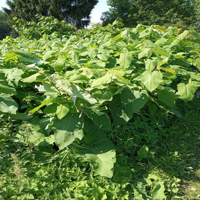

Transformed Image: ../Downloading_images/data/train\593040\48796355_t.jpg


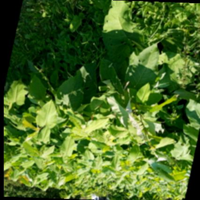

In [25]:
print_original_and_transformed(train_input_dir)